In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function = embeddings,
    collection_name = 'income_tax_collection2',
    persist_directory = './income_tax_collection2'
)

retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph
    
class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [3]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    
    return {'context': docs}

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [ ]:
from langchain import hub

generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100) # LLM이 최대 100 토큰까지만 답변을 생성하도록 함.

def generate(state: AgentState):
    query = state['query']
    context = state['context']
    rag_chain = generate_prompt | generate_llm
    
    response = rag_chain.invoke({'question':query, 'context':context})
    
    return {'answer': response.content}



In [6]:
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']
    context = state['context']
    print(f'query: {query}')
    
    doc_relevance_chain = doc_relevance_prompt  | llm
    response = doc_relevance_chain.invoke({'question':query, 'documents':context})
    print(f'response doc relevance: {response}')
    
    if response['Score'] == 1:
        return 'relevant'
    return 'irrelevant'
    

In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

dictionary = ["사람을 나타내는 표현 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(f"""
        우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
        사전: {dictionary}
        질문: {{question}}     
""")


def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    
    response = rewrite_chain.invoke({'question': query})
    return {'query': response}

In [8]:
from langchain import hub
from langchain_core.prompts import PromptTemplate

hallucination_prompt = PromptTemplate.from_template(""" 
    You are a teacher tasked with evaluating whether a student`s answer is based on documents or not,
    Given documents, which are excerpts from income tax law, and a student`s answer;
    If the stuendt`s answer is based on documents, respond with "not hallucinated",
    If the student`s answer is not based on documents, respond with "hallucinated".                                          
              
    documents: {documents}
    student_answer: {student_answer}                                      
 """)

hallucination_llm = ChatOpenAI(model='gpt-4o', temperature=0)


def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']
    context = state['context']
    context = [doc.page_content for doc in context]
    print(f'context: {context}')
    
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})
    print(f'hallucination response: {response}')
    
    return response

In [9]:
from langchain import hub

helpfullness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState):
    query = state['query']
    answer = state['answer']

    helpfulness_chain = helpfullness_prompt | llm
    response = helpfulness_chain.invoke({'question': query, 'student_answer': answer})
    print(f'helpfulness response: {response}')
    
    if response['Score'] == 1:
        return 'helpful'
    return 'unhelpful'  


def check_helpfulness(state: AgentState):
    return state

In [ ]:
query = '연봉 5천만원인 거주자의 소득세는 얼마인가요?'
context = retriever.invoke(query)

print('-----document------')
for document in context:
    print(document.page_content)
print('-----document------')

generate_state = {'query': query, 'context': context}
answer = generate(generate_state)
print(f'answer:{answer}')

hallucination_state = {'answer': answer, 'context': context}
helpfulness_state = {'query': query, 'answer': answer}

check_hallucination(hallucination_state)
check_helpfulness(helpfulness_state)

document
③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.
[전문개정 2009. 12. 31.]
[제목개정 2014. 1. 1.]
제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. 
[개정 2014. 1. 1.]
[전문개정 2009. 12. 31.]
[제목개정 2014. 1. 1.]
제2절 세액의 계산 <개정 2009. 12. 31.>
제1관 세율 <개정 2009. 12. 31.>
제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>
종합소득
┌───────────────┐
│ 과세표준의 6개 구간 │
├───────────────┤
│ 1,400만원 이하        │ 84만원 + (1,400만원을 초과하는 금액의 15%)  │
│ 1,400만원 초과        │ 84만원 + (5,000만원을 초과하는 금액의 24%)  │
│ 8,800만원 이하        │ 624만원 + (5,000만원을 초과하는 금액의 24%)  │
│ 8,800만원 초과        │ 1,536만원 + (8,800만원을 초과하는 금액의 35%)  │
│ 1.5억원 초과          │ 4,046만원 + (1,500만원을 초과하는 금액의 38%)  │
│ 

{'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?',
 'answer': {'answer': '연봉 5천만 원인 거주자의 소득세는 624만 원입니다. 이는 5천만 원 초과 금액에 대해 24% 세율이 적용되기 때문입니다.'}}

In [11]:
graph_builder = StateGraph(AgentState)

In [12]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [ ]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')

graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)

graph_builder.add_conditional_edges(
        'generate',
        check_hallucination,
        {
            'not hallucinated': 'check_helpfulness',
            'hallucinated': 'generate'
        }
)

graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)

graph_builder.add_edge('rewrite', 'retrieve')

In [14]:
graph = graph_builder.compile()

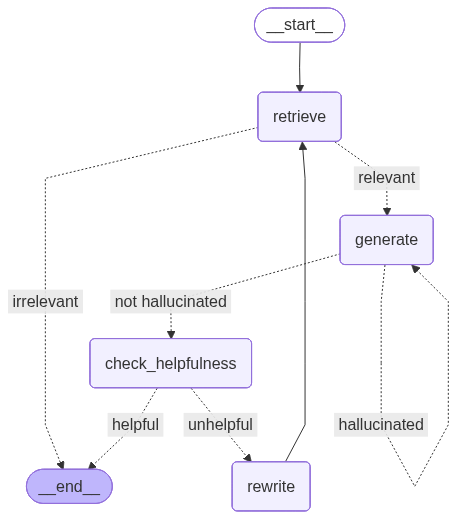

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
initial_state = {'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?'}

graph.invoke(initial_state)

query: 연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?
response doc relevance: {'Score': 1, 'Explanation': "The student's provided facts are excerpts from a document about income tax laws and calculations, particularly focusing on how income tax is determined based on various income brackets. The question asks for the income tax on a specific salary (5천만원), which directly relates to the provided facts as they include detailed tax rate information, such as the income brackets and corresponding tax rates. \n\nFor instance, the document outlines the tax calculation method for different income brackets, including those relevant to determining the tax for an income of 5천만원. Even though the facts contain additional details not directly needed for this specific computation, such as details on capital gains and retirement income, the core information about the income tax brackets and rates is present.\n\nTherefore, the facts are relevant to the question because they provide the necessary framework to calcul

{'query': '연봉 5천만원인 사람이 납부해야 하는 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n│ 과세표준의 6개 구간 │\n├───────────────┤\n│ 1,400만원 이하        │ 84만원 + (1,400만원을 초과하는 금액의 15%)  │\n│ 1,400만원 초과        │ 84만원 + (5,000만원을 초과하는 금액의 24%)  │\n│ 8,800만원 이하        │ 624만원 + (5,000만